In [1]:
import warnings; warnings.simplefilter('ignore')

In [2]:
import matplotlib.pyplot as plt 
import numpy as np
import pystan
from sklearn import decomposition 
from py_stan_code.helper_functions import StanModel_cache

%matplotlib inline 

<h2>Compile Stan Code</h2>

In [3]:
def stan_model(file):
    with open(file) as f:
        stan_code = f.read()
    return StanModel_cache(model_code=stan_code)


file1 = "py_stan_code/ppca_house.stan"
file2 = "py_stan_code/ppca.stan"

ppca_house_model = stan_model(file1)
ppca_model = stan_model(file2)

Using cached StanModel
Using cached StanModel


In [4]:
def run_calc(model, Y, N, D, Q, chains=4, iterations=2000):
    data_dict = {'N':N, 'D':D, 'Q':Q, 'Y':Y}
    samples = model.sampling(data_dict, chains=chains, iter=iterations)
    return samples

<h1>Example Dataset</h1>
<p>Reconstruct own parameters</p>
<p>Because of the ordered eigenvalue vector in stan, in some rare cases there might be some convergence issues (due to random initialization). By looking at the loglikelihood values, those chains can be excluded afterwards.</p>

In [5]:
def haar_measure(D, Q):
    """
    outputs a matrix from stiefel(D, N)
    """
    z = np.random.normal(0,1,size=(D,D))
    q, r = np.linalg.qr(z)
    sign_r = np.sign(np.diag(r))
    return np.matmul(q, np.diag(sign_r))[:,:Q]
    
    
def get_data(N, D, Q, sigma):
    """
    U from stiefel(Q,D) and fixed sigma -> W = U*diag(sigma)
    X from normal 
    output Y = X*W.T
    """
    U = haar_measure(D,Q)
    W = np.matmul(U, np.diag(sigma))
    X = np.random.normal(size=(N, Q))
    return np.matmul(X, W.T) + np.random.normal(0, 0.01, size=(N, D)), U


def sign_convention(U):
    """
    sign convention
    """
    return np.array( [-U[:,q] if U[0,q] < 0 else U[:,q] for q in range(U.shape[1])] ).T

In [6]:
N, D, Q, Q_fit = 100, 4, 2, 2
sigma = (5.0, 1.0,)   # should be of length Q

Y, U = get_data(N, D, Q, sigma)
N,D = Y.shape

In [7]:
%time ppca = run_calc(ppca_model, Y, N, D, Q_fit)
%time ppca_house = run_calc(ppca_house_model, Y, N, D, Q_fit)

CPU times: user 692 ms, sys: 636 ms, total: 1.33 s
Wall time: 7min 31s
CPU times: user 676 ms, sys: 648 ms, total: 1.32 s
Wall time: 8min 23s


In [8]:
# PCA solution
pca = decomposition.PCA(n_components=Q_fit)
pca.fit(Y)
U_pca = pca.components_.T   
U_pca = sign_convention(U_pca)
sigma_pca = np.sqrt(pca.explained_variance_)
W_pca = np.dot(U_pca,np.diag(sigma_pca))

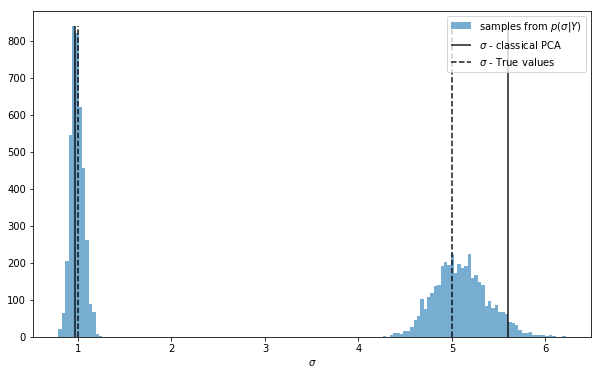

In [9]:
sigma_house = np.concatenate((ppca_house.extract('sigma')['sigma']), axis=0)

fig = plt.figure(figsize=(10,6))
tmp, _, _ = plt.hist(sigma_house, bins=150, alpha=0.6, label='samples from $p(\sigma|Y)$ ')
plt.vlines(sigma_pca, 0, np.max(tmp), alpha=0.9, label='$\sigma$ - classical PCA')
plt.vlines(sigma, 0, np.max(tmp), alpha=0.9, linestyles='dashed' ,label='$\sigma$ - True values')
plt.xlabel('$\sigma$')
plt.legend()
plt.show()

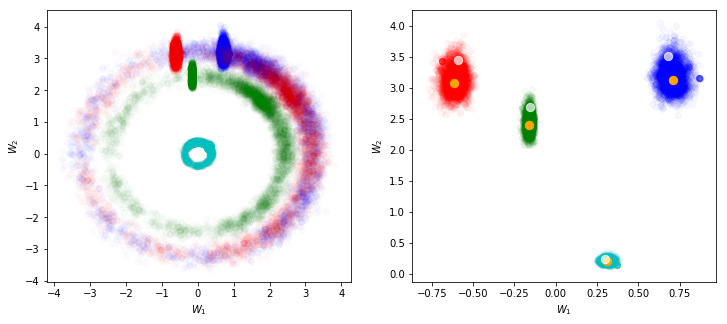

In [10]:
W_ppca = ppca.extract(['W'])['W']
W_house = ppca_house.extract(['W_n'])['W_n']
W_true =  np.dot(sign_convention(U), np.diag(sigma))


c = ['b', 'g', 'r', 'c', 'm', 'y', 'k', 'w']
def plt_info(ax, x=None, y=None, legend=None, title=None):
    if x is not None: ax.set_xlabel(x)
    if y is not None: ax.set_ylabel(y)
    if legend is not None: ax.legend()
    if title is not None: ax.set_title(title)
        

fig = plt.figure(figsize=(12,5))

ax = fig.add_subplot(1,2,1)
for d in range(D):
    ax.scatter(W_ppca[:,d,0], W_ppca[:,d,1], alpha=0.02, c=c[d], rasterized=True)
    ax.scatter(W_house[:,d,0], W_house[:,d,1], alpha=0.05, c=c[d], rasterized=True)
plt_info(ax, '$W_1$', '$W_2$')

ax = fig.add_subplot(1,2,2)
for d in range(D):
    ax.scatter(W_house[:,d,0], W_house[:,d,1], alpha=0.03, c=c[d], rasterized=True)
plt_info(ax, '$W_1$', '$W_2$')

ax.scatter(W_true[:,1], W_true[:,0], marker='o', s=70, c='orange')
ax.scatter(W_pca[:,1], W_pca[:,0], marker='o', s=70,  c='w', alpha=0.7)

plt.show()

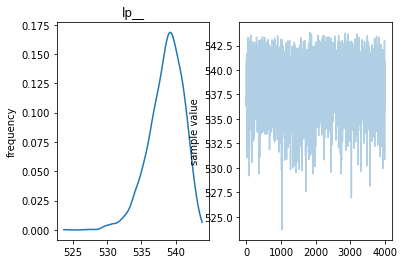

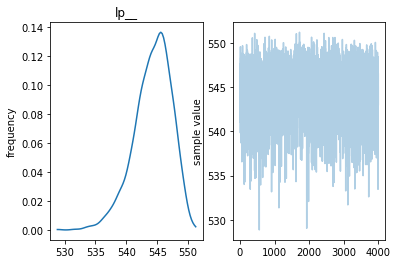

In [11]:
ppca.plot(['lp__'])
ppca_house.plot(['lp__']);

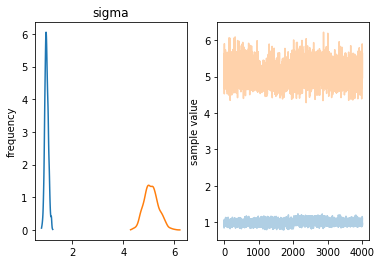

In [12]:
ppca_house.plot(['sigma']);